In [1]:
import tal
import os

# TODO: if you want to follow this tutorial,
# you need to have rendered the scene using the "tal render nlos-z" shell command
# See README.md for more information
# Write here   vvvvvvvvvvvvv   the path to your rendered scene
data=[]
root = './n-los/10m'

data = tal.io.read_capture(os.path.join(root, 'n-los.hdf5'))

In [2]:
# because this is a test scene, we know the hidden geometry
# is located at Z = 1
# this volume_xyz is coplanar to the relay wall (rw) at Z=1
volume_xyz = tal.reconstruct.get_volume_project_rw(data, depths=[1.0,])

In [3]:
import xml.etree.ElementTree as ET

def get_sample_count(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return int(root.find('.//sampler[@type="independent"]/integer[@name="sample_count"]').get('value'))


In [34]:
import matplotlib.pyplot as plt
from tal.io.capture_data import NLOSCaptureData
import numpy as np
import scipy.stats as stats

def kernel_binomial(kernel_size, samples, CTP):
    
    kernel = stats.binom.rvs(samples, CTP, size=(kernel_size, kernel_size)) / samples
    kernel[kernel_size // 2, kernel_size // 2] = 0
    
    return kernel

def crosstalk(vector: np.ndarray, kernel_size, samples, CTP):
    if kernel_size == 1:
        return vector
    result = np.copy(vector)

    half_k = kernel_size // 2
    
    for i in range(half_k, vector.shape[0] - half_k):
        for j in range(half_k, vector.shape[1] - half_k):
            
            kernel = kernel_binomial(kernel_size, samples, CTP)
            
            region = vector[i-half_k:i+half_k+1, j-half_k:j+half_k+1]
            
            conv_value = np.sum(region * kernel)
            
            result[i, j] = vector[i, j] - (vector[i, j] * np.sum(kernel)) + conv_value
    
    return result

def plot_amplitude_cross(vector: np.ndarray, kernel_size, samples, CTP, title: str = '', cmap='hot'):
    vector.squeeze().T
    result = crosstalk(vector, kernel_size, samples, CTP)
    result = np.rot90(result, k=-1)
    result = np.flip(result, axis=1)

    # Configurar la figura y el eje
    fig, ax = plt.subplots(figsize=(6, 5))
    mappable = ax.imshow(np.abs(result), cmap=cmap)
    
    # Añadir barra de color
    fig.colorbar(mappable, ax=ax)
    
    # Configurar etiquetas y título
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Mostrar la imagen
    plt.show()

tal.reconstruct.filter_H: Using wavelengths from 0.0399m to 0.1288m


tal.reconstruct.filter_H (pf, 3/3): 100%|██████████| 3/3 [00:00<00:00, 15.12it/s]


tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3


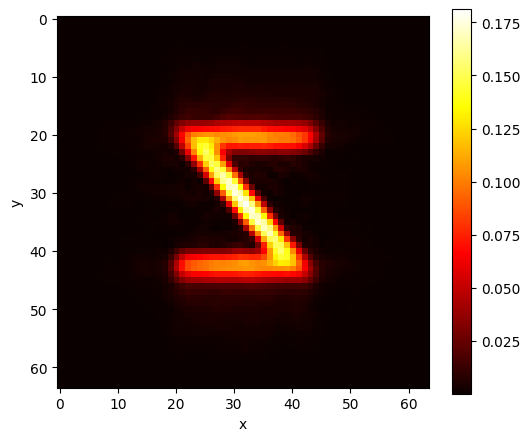

In [35]:
samples = get_sample_count(os.path.join(root, 'nlos_scene.xml'))
H_1 = tal.reconstruct.fbp.solve(data,
                                wl_mean=0.06, wl_sigma=0.06,
                                volume_xyz=volume_xyz, camera_system=tal.enums.CameraSystem.DIRECT_LIGHT)

plot_amplitude_cross(H_1, 3, samples, 0.1)